In [ ]:
!pip install opencv-python-headless --user
!pip install albumentations --user


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip show albumentations

Name: albumentations
Version: 1.4.21
Summary: Fast, flexible, and advanced image augmentation library for deep learning and computer vision. Albumentations offers a wide range of transformations for images, masks, bounding boxes, and keypoints, with optimized performance and seamless integration into ML workflows.
Home-page: https://albumentations.ai
Author: Vladimir Iglovikov
Author-email: 
License: MIT License

Copyright (c) 2017 Vladimir Iglovikov, Alexander Buslaev, Alexander Parinov,

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import albumentations as A

# Define dataset path and image size
dataset_path = "data"
image_size = (64, 48)

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4', 'Grupo_5']


Step 1: Loading DataSet

In [ ]:


# Function to load images
def load_images_from_folder(folder_path, max_depth=5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)
        if 'LG' in root:
            current_depth -= 1

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, image_size)
                            images.append(img)
                            labels.append(file[6] != '0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
        else:
            del dirs[:]

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    return np.array(images), np.array(labels), np.array(names)

# Load dataset
images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")


Following 0 files are corrupt or encountered error: 
 []
Read 25201 images from the data folder with shape (25201, 48, 64)


Step 2: Data Augmentation

In [9]:
# Augmentation pipeline
augmentation_pipeline = A.Compose([
    A.Rotate(limit=10, p=0.5),  # Rotate by ±10 degrees
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.15, rotate_limit=0, p=0.5),  # Shift by 20%, Zoom by 15%
    A.Resize(64, 48),  # Ensure consistent size
    A.HorizontalFlip(p=0.5),  # Optional flip for additional variety
])

def augment_image(image):
    augmented = augmentation_pipeline(image=image)
    return augmented['image']


Step 3: Split images and labels into 80-20 random train test split and train cnn

In [13]:
# Split dataset
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=20)

# Resize original training images to match the augmented images' shape (48, 64)
images_train_resized = np.array([cv2.resize(img, (64, 48)) for img in images_train])

# Augment training images
images_train_augmented = np.array([augment_image(img) for img in images_train_resized])

# Resize augmented images to (48, 64) to match the original image size
images_train_augmented_resized = np.array([cv2.resize(img, (64, 48)) for img in images_train_augmented])

# Add channel dimension for grayscale (both original and augmented images)
images_train_resized = images_train_resized[..., np.newaxis]
images_train_augmented_resized = images_train_augmented_resized[..., np.newaxis]
images_test = images_test[..., np.newaxis]  # Test images also need a channel dimension

# Check if the shapes match
print(f"Original train images shape: {images_train_resized.shape}")
print(f"Augmented train images shape: {images_train_augmented_resized.shape}")

# Convert labels to one-hot encoding
labels_train_cnn = to_categorical(labels_train, num_classes=2)
labels_test_cnn = to_categorical(labels_test, num_classes=2)

# Combine original and augmented training data
images_train_combined = np.concatenate([images_train_resized, images_train_augmented_resized], axis=0)
labels_train_combined = np.concatenate([labels_train_cnn, labels_train_cnn], axis=0)

# Check if the combined shapes are correct
print(f"Combined train images shape: {images_train_combined.shape}")
print(f"Combined labels shape: {labels_train_combined.shape}")

# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with both original and augmented images
cnn_model.fit(images_train_combined, labels_train_combined, epochs=10, batch_size=32, validation_data=(images_test, labels_test_cnn))


Original train images shape: (20160, 48, 64, 1)
Augmented train images shape: (20160, 48, 64, 1)
Combined train images shape: (40320, 48, 64, 1)
Combined labels shape: (40320, 2)
Epoch 1/10


c:\Users\Sneha Thakur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1260/1260 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.7982 - loss: 1.8063 - val_accuracy: 0.9040 - val_loss: 0.2695
Epoch 2/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.8531 - loss: 0.3682 - val_accuracy: 0.9260 - val_loss: 0.1963
Epoch 3/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8767 - loss: 0.3102 - val_accuracy: 0.9484 - val_loss: 0.1505
Epoch 4/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8881 - loss: 0.2824 - val_accuracy: 0.9575 - val_loss: 0.1237
Epoch 5/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8946 - loss: 0.2648 - val_accuracy: 0.9645 - val_loss: 0.1102
Epoch 6/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9008 - loss: 0.2471 - val_accuracy: 0.9651 - val_loss: 0.1029
Epoch 7/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9089 - loss: 0.2243 - val_accuracy: 0.9665 - val_loss: 0.0972
Epoch 8/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9112 - loss: 0.22

In [14]:

# Test the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(images_test, labels_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")


158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9728 - loss: 0.0837
CNN Test Accuracy: 97.06%


Demonstration

In [25]:
totalTest = 0
correctTest = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Text(0.5, 1.0, 'Name: E_3_2_1_R_M_N_N_1986_56_2017.bmp\n\nPrediction: Alcoholic\nActual: Alcoholic\n\nAccuracy: 0.95')

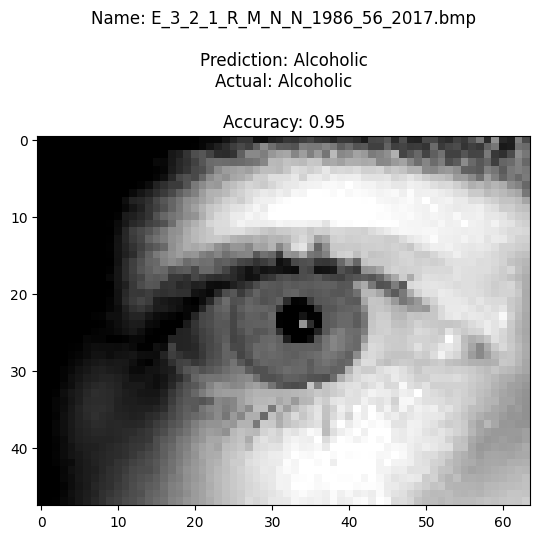

In [45]:
# Test with a random image
import random
# testImagePath = 'data/Grupo_5/E_5_7/Iritech/E_5_7_0/E_5_7_0_L_F_N_N_1994_0_2017.bmp'
# testImg = cv2.imread(testImagePath, cv2.IMREAD_GRAYSCALE)

r_in = random.randint(0, len(images) - 1)

testImg = images[r_in]
testLabel = labels[r_in]
testImg = cv2.resize(testImg, image_size)

plt.imshow(testImg, cmap='gray')

testImg = np.expand_dims(testImg, axis=-1) 
testImg = np.expand_dims(testImg, axis=0)


prediction = cnn_model.predict(testImg)
prediction = np.argmax(prediction[0])

totalTest +=1
correctTest += prediction==testLabel

prediction = 'Alcoholic' if prediction else 'Fit for duty'
testLabel = 'Alcoholic' if testLabel else 'Fit for duty'
plt.title(f'Name: {names[r_in]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest/totalTest}')